In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

# Part I

## data preprocessing

In [2]:

category=['zero','one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve','thirteen','fourteen','fifteen','sixteen','draw']
category_dict={} # 
for i,s in enumerate(category):
    category_dict[s]=i

char=['a','b','c','d','e','f','g','h']
char_dict={}
for i,s in enumerate(char,start=1):
    char_dict[s]=i

data_temp=[]
with open("datasets/Chess/trainset.csv") as f:
    count=0
    for line in f:
        count+=1
        if count!=1:
            line=line.strip().split(',')
            data_temp.append([char_dict[line[0]],int(line[1]),char_dict[line[2]],int(line[3]),char_dict[line[4]],int(line[5]),category_dict[line[6]]])
train_data=np.array(data_temp)

data_temp=[]
with open("datasets/Chess/testset.csv") as f:
    count=0
    for line in f:
        count+=1
        if count!=1:
            line=line.strip().split(',')
            data_temp.append([char_dict[line[0]],int(line[1]),char_dict[line[2]],int(line[3]),char_dict[line[4]],int(line[5]),category_dict[line[6]]])
test_data=np.array(data_temp)

np.save("datasets/Chess/train_data.npy",train_data)
np.save("datasets/Chess/test_data.npy",test_data)

## utils

In [204]:
# data independent
def classification_evaluation(testset,testlabel,ypred):
    Accuracy=(Counter(np.equal(ypred,testlabel))[True])/testlabel.shape[0]
    
    category=np.unique(testlabel)
    evaluation=np.zeros((category.shape[0],4),dtype=int)#4: TP,FP,FN,TN
    for c in category:
        evaluation[c,0]=np.count_nonzero(np.logical_and((testlabel==c),(ypred==c)))#TP
        evaluation[c,1]=np.count_nonzero(np.logical_and((testlabel!=c),(ypred==c)))#FP
        evaluation[c,2]=np.count_nonzero(np.logical_and((testlabel==c),(ypred!=c)))#FN
        evaluation[c,3]=np.count_nonzero(np.logical_and((testlabel!=c),(ypred!=c)))#TN
        
    Macro_P=evaluation[:,0]/(evaluation[:,0]+evaluation[:,1])
    Macro_R=evaluation[:,0]/(evaluation[:,0]+evaluation[:,2])
    Macro_F1=(2*Macro_P*Macro_R/(Macro_P+Macro_R)).mean()
    
    reduced_evaluation=evaluation.sum(axis=0)
    Micro_P=reduced_evaluation[0]/(reduced_evaluation[0]+reduced_evaluation[1])
    Micro_R=reduced_evaluation[0]/(reduced_evaluation[0]+reduced_evaluation[2])
    Micro_F1=2*Micro_P*Micro_R/(Micro_P+Micro_R)
    return ypred,Accuracy,Macro_F1,Micro_F1

In [409]:
# data independent
# for 5-folf cross validation
def split_data_5_fold(train_data):
    step=train_data.shape[0]//5
    for i in range(5):
        begin_test=i*step
        end_test=(i+1)*step
        trainset=np.vstack((train_data[0:begin_test,:6],train_data[end_test:,:6]))
        trainlabel=np.hstack((train_data[0:begin_test,6],train_data[end_test:,6]))
        testset=train_data[begin_test:end_test,:6]
        testlabel=train_data[begin_test:end_test,6]
        yield i,trainset,trainlabel,testset,testlabel

## common precedure

need to paste to all seperate files

In [210]:
train_data=np.load("datasets/Chess/train_data.npy")
test_data=np.load("datasets/Chess/test_data.npy")
np.random.shuffle(train_data)

In [211]:
train_data.shape,test_data.shape

((22445, 7), (5611, 7))

## kNN

In [159]:
# retuen ypred,Accuracy,Macro_F1,Micro_F1
# No 5-fold cross validation
# category: from 0 :int (MUST)
def kNN(trainset,trainlabel,testset,testlabel,k):
    #predict
    ypred=np.empty(testset.shape[0],dtype=testlabel.dtype)
    for i,X in enumerate(testset):
        ypred[i]=np.bincount(trainlabel[np.argsort(np.linalg.norm(X-trainset,axis=1))[:k]]).argmax()
    #evaluation
    return classification_evaluation(testset,testlabel,ypred)

In [408]:
#5-fold cross validation
k_parameter=[i for i in range(1,4,2)]
Micro_F1_matrix=np.zeros((len(k_parameter),5),dtype=float)
step=train_data.shape[0]//5
for k_i in range(len(k_parameter)):
    k=k_parameter[k_i]
    for i,trainset,trainlabel,testset,testlabel in split_data_5_fold(train_data):        
        ypred,Accuracy,Macro_F1,Micro_F1=kNN(trainset,trainlabel,testset,testlabel,k)
        Micro_F1_matrix[k_i,i]=Micro_F1
        print("k={},fold={},Micro_F1={}".format(k,i,Micro_F1))

k=1,fold=0,Micro_F1=0.537090666072622
k=1,fold=1,Micro_F1=0.5317442637558476
k=1,fold=2,Micro_F1=0.5453330363109824
k=1,fold=3,Micro_F1=0.5290710625974605
k=1,fold=4,Micro_F1=0.5266206282022722
k=3,fold=0,Micro_F1=0.6150590331922478
k=3,fold=1,Micro_F1=0.6036979282691023
k=3,fold=2,Micro_F1=0.6065938961906884
k=3,fold=3,Micro_F1=0.6028068612163066
k=3,fold=4,Micro_F1=0.6019157941635108


In [185]:
#5-fold cross validation
k_parameter=[i for i in range(1,20,2)]
Micro_F1_matrix=np.zeros((len(k_parameter),5),dtype=float)
step=train_data.shape[0]//5
for k_i in range(len(k_parameter)):
    k=k_parameter[k_i]
    for i in range(5):#5-fold
        begin_test=i*step
        end_test=(i+1)*step
        trainset=np.vstack((train_data[0:begin_test,:6],train_data[end_test:,:6]))
        trainlabel=np.hstack((train_data[0:begin_test,6],train_data[end_test:,6]))
        testset=train_data[begin_test:end_test,:6]
        testlabel=train_data[begin_test:end_test,6]
        
        ypred,Accuracy,Macro_F1,Micro_F1=kNN(trainset,trainlabel,testset,testlabel,k)
        Micro_F1_matrix[k_i,i]=Micro_F1
        print("k={},fold={},Micro_F1={}".format(k,i,Micro_F1))

k=1,fold=0,Micro_F1=0.5431053686789931


/home/drdh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


k=1,fold=1,Micro_F1=0.5297393628870573
k=1,fold=2,Micro_F1=0.5206059255959011
k=1,fold=3,Micro_F1=0.5290710625974605
k=1,fold=4,Micro_F1=0.5424370683893963
k=3,fold=0,Micro_F1=0.6179550011138338
k=3,fold=1,Micro_F1=0.601470260637113
k=3,fold=2,Micro_F1=0.5985742927155269
k=3,fold=3,Micro_F1=0.5965693918467365
k=3,fold=4,Micro_F1=0.6110492314546669
k=5,fold=0,Micro_F1=0.7210960124749387
k=5,fold=1,Micro_F1=0.7311205168188907
k=5,fold=2,Micro_F1=0.7086210737357987
k=5,fold=3,Micro_F1=0.7112942748941858
k=5,fold=4,Micro_F1=0.7222098462909334
k=7,fold=0,Micro_F1=0.7288928491869014
k=7,fold=1,Micro_F1=0.7259968812653153
k=7,fold=2,Micro_F1=0.7148585431053688
k=7,fold=3,Micro_F1=0.7141902428157718
k=7,fold=4,Micro_F1=0.736466919135665
k=9,fold=0,Micro_F1=0.7014925373134329
k=9,fold=1,Micro_F1=0.7017153040766317
k=9,fold=2,Micro_F1=0.6894631321006905
k=9,fold=3,Micro_F1=0.6907997326798841
k=9,fold=4,Micro_F1=0.7068389396302072
k=11,fold=0,Micro_F1=0.6792158609935398
k=11,fold=1,Micro_F1=0.684

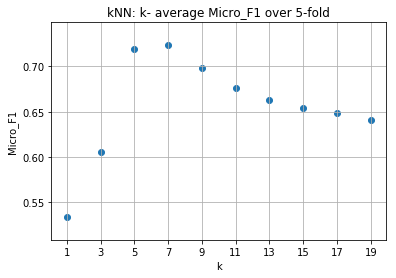

In [200]:
Micro_F1_mean=Micro_F1_matrix.mean(axis=1)
plt.figure(1)
plt.scatter(k_parameter,Micro_F1_mean)
plt.title("kNN: k- average Micro_F1 over 5-fold")
plt.grid(True)
plt.ylabel("Micro_F1")
plt.xlabel("k")
plt.xticks(k_parameter)
plt.savefig("graph/PartI/kNN/k_Micro_F1.png",dpi=1000)
plt.show()

In [208]:
for i in zip(k_parameter,Micro_F1_mean):
    print(i)

(1, 0.5329917576297617)
(3, 0.6051236355535754)
(5, 0.7188683448429494)
(7, 0.7240810871018044)
(9, 0.6980619291601693)
(11, 0.6760080196034751)
(13, 0.6625083537536199)
(15, 0.6543105368678993)
(17, 0.6485186010247271)
(19, 0.6404989975495656)


In [203]:
# test
k=k_parameter[Micro_F1_mean.argmax()]
ypred,Accuracy,Macro_F1,Micro_F1=kNN(train_data[:,:6],train_data[:,6],test_data[:,:6],test_data[:,6],k)
print(Accuracy,Macro_F1,Micro_F1)

0.7820352878274818 0.7183239169477872 0.7820352878274818


## decisionTree

In [397]:
def createTree(trainset,trainlabel,testset,testlabel):
    attribute=[i for i in range(trainset.shape[1])]
    attribute_length=len(attribute)
    attribute_value=[np.unique(trainset[:,i]) for i in range(6)]
    
    def chooseBestFeature(trainset,trainlabel,attribute):
        def Ent(trainlabel):
            category_count=np.bincount(trainlabel)
            categoty_probability=category_count[category_count.nonzero()]/trainlabel.shape[0]
            return -(categoty_probability*np.log(categoty_probability)/np.log(2)).sum()
        
        gain=np.full(attribute_length,-np.inf)
        Ent_D=Ent(trainlabel)
        for a in attribute:
            gain[a]=Ent_D
            for v in np.unique(trainset[:,a]):
                D_v_index=(trainset[:,a]==v)
                gain[a]-=D_v_index.sum()/trainset.shape[0]*Ent(trainlabel[D_v_index])
        return gain.argmax()
        
    def treeGenerate(trainset,trainlabel,attribute):
        if np.equal(trainlabel,trainlabel[0]).all():#same category
            return trainlabel[0]
        if len(attribute)==0 or np.equal(trainset,trainset[0]).all():
            return np.bincount(trainlabel).argmax()
        attr=chooseBestFeature(trainset,trainlabel,attribute)
        attribute=attribute.copy()
        attribute.remove(attr)
        subtree={}
        for v in attribute_value[attr]:
            D_v_index=(trainset[:,attr]==v)
            if D_v_index.sum()==0:
                subtree[str(attr)+':'+str(v)]=np.bincount(trainlabel).argmax()
            else:
                subtree[str(attr)+':'+str(v)]=treeGenerate(trainset[D_v_index],trainlabel[D_v_index],attribute)
        return subtree
        
    def predict(tree,X):
        if type(tree)==dict:
            attr=int(list(tree.keys())[0][0])
            return predict(tree[str(attr)+':'+str(X[attr])],X)
        else:
            return tree
        
    tree=treeGenerate(trainset,trainlabel,attribute)
    #predict
    ypred=np.empty(testset.shape[0],dtype=testlabel.dtype)
    for i,X in enumerate(testset):
        ypred[i]=predict(tree,X)
    #evaluation
    return classification_evaluation(testset,testlabel,ypred)

In [411]:
#5-fold cross validation
Micro_F1_matrix=np.zeros((len(k_parameter),5),dtype=float)
for i,trainset,trainlabel,testset,testlabel in split_data_5_fold(train_data):        
    ypred,Accuracy,Macro_F1,Micro_F1=createTree(trainset,trainlabel,testset,testlabel)
    Micro_F1_matrix[k_i,i]=Micro_F1
    print("fold={},Micro_F1={}".format(i,Micro_F1))

fold=0,Micro_F1=0.5582535085765203
fold=1,Micro_F1=0.5591445756293161
fold=2,Micro_F1=0.5642682111828915
fold=3,Micro_F1=0.5593673423925151
fold=4,Micro_F1=0.5544664736021385


In [412]:
#test
ypred,Accuracy,Macro_F1,Micro_F1=createTree(train_data[:,:6],train_data[:,6],test_data[:,:6],test_data[:,6])
print(Accuracy,Macro_F1,Micro_F1)

0.5963286401710925 0.5495741554985076 0.5963286401710925


In [415]:
# decision tree visualization ==> HOW ?

## SVM

In [416]:
def multiClassSVM(trainset,trainlabel,testset,testlabel):
    def softSVM(trainset,trainlabel,sigma,C):
        pass